In [2]:
# TODO - find a way to make this install the poetry enviorment
import os
os.chdir("C:\\Users\yuvmi\PycharmProjects\SequenceModelLab")
!poetry install

Installing dependencies from lock file

No dependencies to install or update


In [3]:
import os
import glob
import pickle
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter, PillowWriter

## Reading result logs

In [4]:
class Result():
    
    def __init__(self, data):
        losses = np.array([l.entity for l in data["loss"]])
        l_epochs = np.array([l.epoch_logged for l in data["loss"]])
        exploded = (np.argmax(losses) == len(losses) - 1)
        min_loss = np.min(losses)
        best_ker = data["kernel"][np.argmin(losses)-1].entity
        
        self.min_loss = min_loss
        self.exploded = exploded
        self.best_ker = best_ker
        self.epoch_best_res = np.argmin(losses)

In [ ]:
experiment_file_r = r".\src\results\lag_exp\*"

experiments_results = defaultdict(dict)
for file_path in tqdm(glob.glob(experiment_file_r)):
    file_name = os.path.basename(file_path)
    exp_name = "_".join(file_name.split('_')[1:-1])
    exp_num = int(file_name.split('_')[-1])
    with open(file_path,"rb") as f:
        data = pickle.load(f)
        experiments_results[exp_name][exp_num] = Result(data)

  0%|          | 0/210 [00:00<?, ?it/s]

In [6]:
# file_path = r"C:\Users\yuvmi\PycharmProjects\SequenceModelLab\src\results\lag_exp\fast_fssm_bd_60"
# file_name = os.path.basename(file_path)
# exp_name = "_".join(file_name.split('_')[1:-1])
# exp_num = int(file_name.split('_')[-1])
# with open(file_path,"rb") as f:
#     data = pickle.load(f)
# A = data["A"][-2].entity
# B = data["B"][-2].entity
# C = data["C"][-2].entity
# D = data["D"][-2].entity
# A.shape,B.shape,C.shape,D.shape

In [7]:
# for i in range(len(data["A"])):
#     print(i)
#     A = data["A"][-2].entity
#     plt.plot()
#     plt.imshow(A, cmap='hot', interpolation='nearest')
#     plt.show()

## Analysis

### Analysing loss at different lags

In [8]:
def save_loss_plot(lag_nums, min_losses, exploaded, exp_name,save_path):
    plt.figure()
    plt.plot(lag_nums,min_losses)
    scatter, = plt.plot(lag_nums[exploded],min_losses[exploded],"o", color = "red")
    scatter.set_label('exploded while training')
    scatter, = plt.plot(lag_nums[~exploded],min_losses[~exploded],"o", color = "green")
    scatter.set_label('finished gracefully')
    plt.title(exp_name)
    plt.xlabel("lag")
    plt.ylabel("min train loss")
    plt.legend()
    plt.savefig(save_path)

fssm_bd
fssm_sd
fssm_ud
hippo
hippo_disc


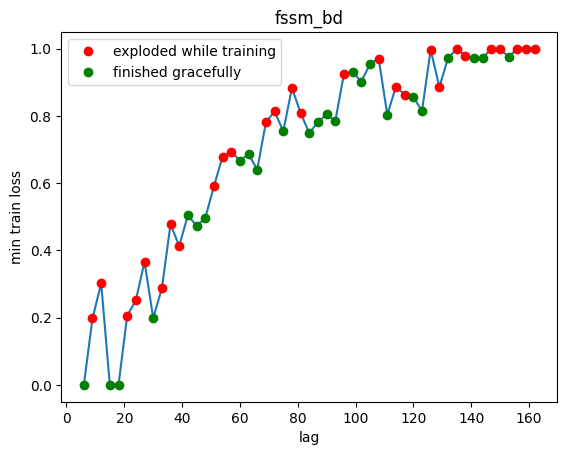

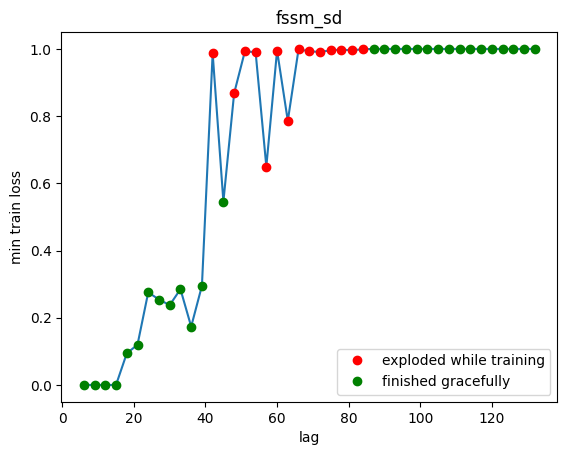

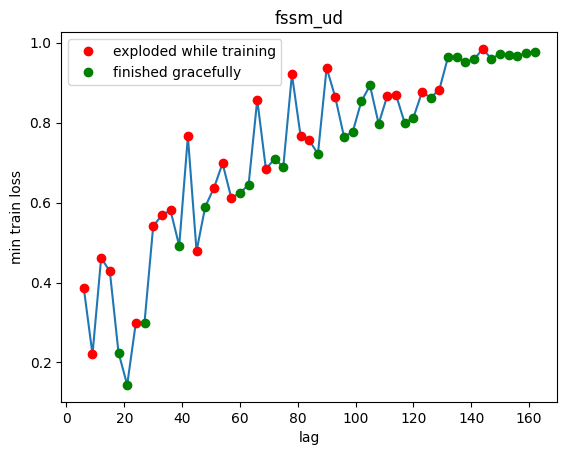

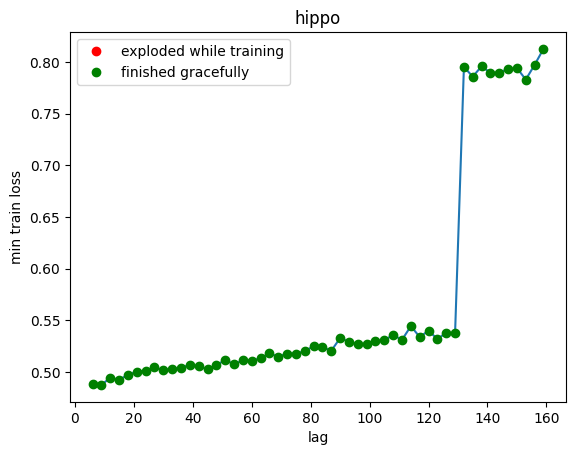

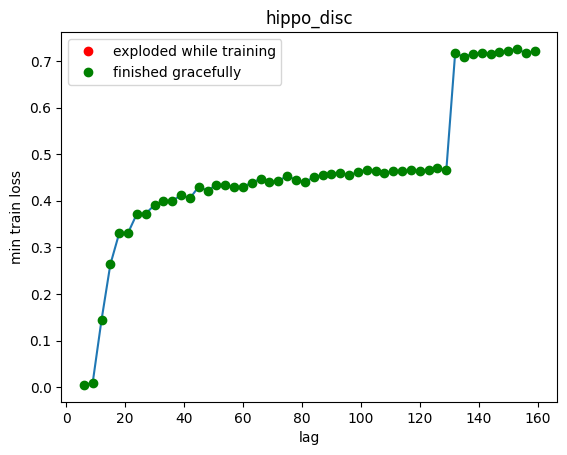

In [9]:
for exp_name in experiments_results.keys():
    print(exp_name)
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    min_losses = np.array([experiments_results[exp_name][lag_num].min_loss for lag_num in lag_nums])
    exploded = np.array([experiments_results[exp_name][lag_num].exploded for lag_num in lag_nums])
    save_loss_plot(lag_nums, min_losses, exploded, exp_name,".\\analysis\\lags_different_ssm_model_results\\loss_plot_"+exp_name+".png")

In [22]:
exp_name = "hippo"
lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
lag_nums.sort()
min_losses = np.array([experiments_results[exp_name][lag_num].min_loss for lag_num in lag_nums])
exploded = np.array([experiments_results[exp_name][lag_num].exploded for lag_num in lag_nums])
lag_nums[41:]

array([129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159])

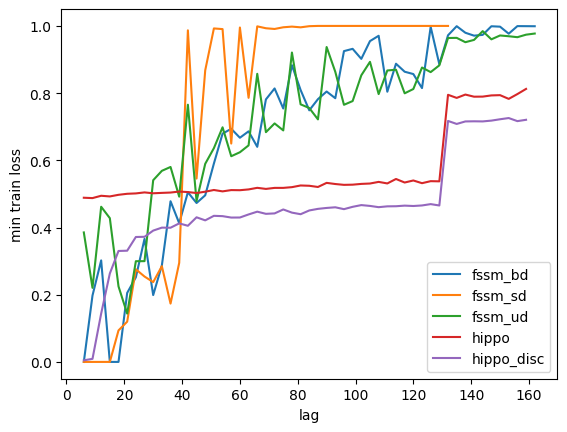

In [15]:
plt.figure()
for exp_name in experiments_results.keys():
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    min_losses = np.array([experiments_results[exp_name][lag_num].min_loss for lag_num in lag_nums])
    plt.plot(lag_nums,min_losses,label = exp_name)
plt.xlabel("lag")
plt.ylabel("min train loss")
plt.legend()
plt.savefig(".\\analysis\\lags_different_ssm_model_results\\all_loss_plots.png")

### Creating kernel videos

In [10]:
def plot_single_kernel_frame(kernel, lag):
    plt.title("lag=%d"%lag)
    plt.plot(lag,kernel[lag],"o",color = "red")
    plt.plot(kernel)
    ax = plt.gca()
    ax.set_ylim([0, max(np.max(kernel),0.7)])

In [11]:

def make_videos_from_list_of_arrays(arrays, lags, save_path):
    writer = FFMpegWriter(fps=3)
    img = [] # some array of images
    frames = [] # for storing the generated images
    fig = plt.figure()
    with writer.saving(fig, save_path, 100):
        for i in tqdm(range(len(arrays))):
            fig.clear()
            plot_single_kernel_frame(arrays[i], lags[i])
            writer.grab_frame()



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

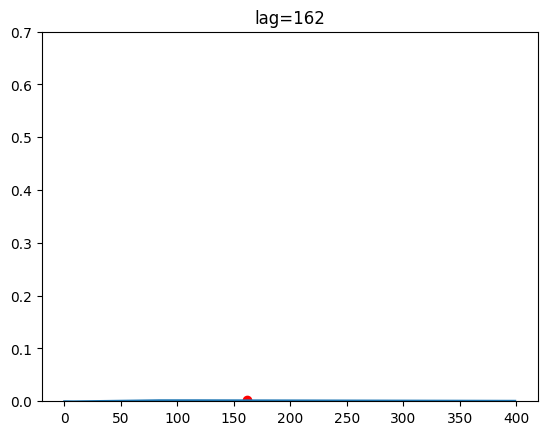

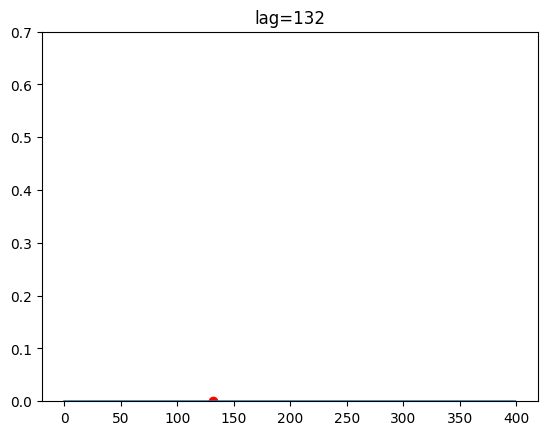

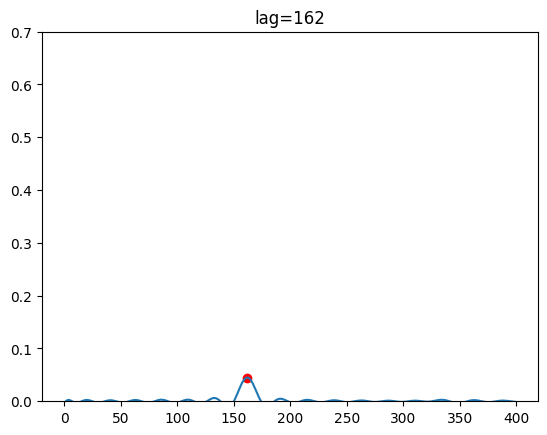

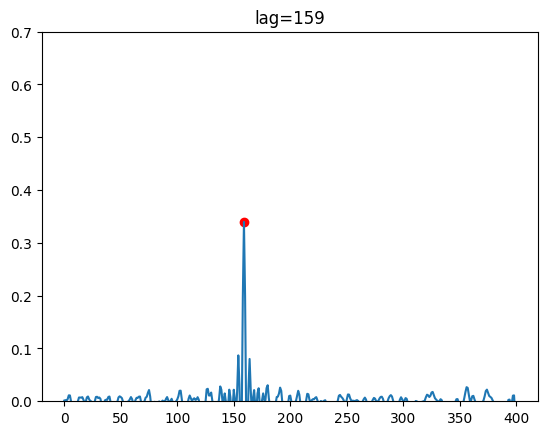

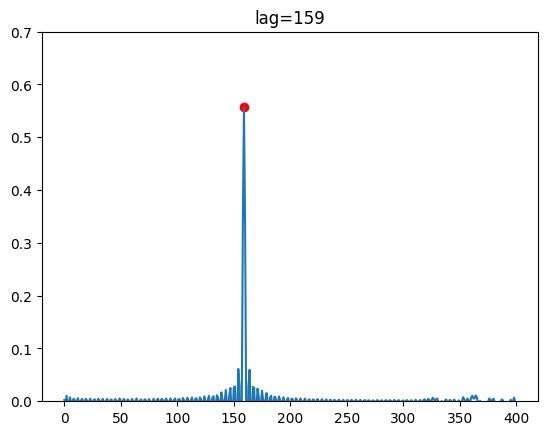

In [12]:
for exp_name in tqdm(experiments_results.keys()):
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    ordered_kernels = np.array([experiments_results[exp_name][lag_num].best_ker for lag_num in lag_nums])
    make_videos_from_list_of_arrays(ordered_kernels, lag_nums,".\\analysis\\lags_different_ssm_model_results\\kernel_vid_"+exp_name+".mp4")